# Unveiling the Traces of Fraud:

**Our investigative journey begins with a credit card transaction dataset where privacy is paramount: most columns (V1 to V28) are principal components from a PCA analysis, keeping the original data confidential. Only 'Time' (the elapsed time in seconds since the first transaction) and 'Amount' (the transaction value) remain in their original, non-anonymized form. Our goal is to comb through this data in search of patterns that differentiate genuine transactions from fraudulent ones (Class == 1).**

**To kick off our hunt for fraud traces, we'll first equip our digital lab: we'll import the essential libraries, tweak some configurations to optimize our analysis, and, of course, load our credit card transaction dataset.**

In [1]:
# Import necessary libraries
import matplotlib.pyplot as plt
from matplotlib.ticker import EngFormatter
import numpy as np
import pandas as pd
import seaborn as sns

from scipy.stats import mannwhitneyu


# Import configuration
from src.config import ORIGINAL_DATA, PROCESSED_DATA
from src.models import RANDOM_STATE

sns.set_theme(palette="bright")

# Read data from a compressed CSV file (specified by ORIGINAL_DATA) into a pandas DataFrame
df = pd.read_csv(ORIGINAL_DATA, compression="zip")

## First Analysis

**With our environment configured and the data in hand, it's time for a detailed initial inspection:**

- **First and Last Clues (.head(), .tail()): We'll peek at the beginning and end of our dataset to get an initial feel for the records.**

- **Data X-Ray (.info()): We'll investigate the complete structure, checking the types of each column (especially V1-V28 and the non-anonymized Time and Amount) and if there's any missing data that could compromise our analysis.**

- **Statistical Portrait (.describe()): We'll analyze descriptive statistics for numerical columns (like Time and Amount, and also the PCA components) to understand their scales, averages, and dispersions.**

- **Focus on the Target (Class): And, crucially, we'll examine the distribution of our target variable Class. This will tell us the proportion of fraudulent transactions relative to genuine ones, a vital point for understanding data imbalance and planning our modeling strategies.**

**This first sweep will give us a solid foundation for the next steps in our fraud investigation.**

In [2]:
# Temporarily set pandas display option to show up to 31 columns
with pd.option_context("display.max_columns", 31):
    display(df.head())      # Display the first few rows of the DataFrame with the adjusted column display limit

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [3]:
# Temporarily set pandas display option to show up to 31 columns
with pd.option_context("display.max_columns", 31):
    display(df.tail())      # Display the last few rows of the DataFrame with the adjusted column display limit

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
284802,172786.0,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,4.356170,-1.593105,2.711941,-0.689256,4.626942,-0.924459,1.107641,1.991691,0.510632,-0.682920,1.475829,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0.77,0
284803,172787.0,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,-0.975926,-0.150189,0.915802,1.214756,-0.675143,1.164931,-0.711757,-0.025693,-1.221179,-1.545556,0.059616,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,24.79,0
284804,172788.0,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,-0.484782,0.411614,0.063119,-0.183699,-0.510602,1.329284,0.140716,0.313502,0.395652,-0.577252,0.001396,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,67.88,0
284805,172788.0,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,-0.399126,-1.933849,-0.962886,-1.042082,0.449624,1.962563,-0.608577,0.509928,1.113981,2.897849,0.127434,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,10.00,0
284806,172792.0,-0.533413,-0.189733,0.703337,-0.506271,-0.012546,-0.649617,1.577006,-0.414650,0.486180,-0.915427,-1.040458,-0.031513,-0.188093,-0.084316,0.041333,-0.302620,-0.660377,0.167430,-0.256117,0.382948,0.261057,0.643078,0.376777,0.008797,-0.473649,-0.818267,-0.002415,0.013649,217.00,0


In [4]:
# Print a concise summary of the DataFrame
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [5]:
# Temporarily set pandas display options: show all columns and format floats to 2 decimal places
with pd.option_context("display.max_columns", None, "display.float_format", "{:.2f}".format):
    display(df.describe())      # Display descriptive statistics (count, mean, std, etc.) for the DataFrame

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00
mean,94813.86,0.00,0.00,-0.00,0.00,0.00,0.00,-0.00,0.00,-0.00,0.00,0.00,-0.00,0.00,0.00,0.00,0.00,-0.00,0.00,0.00,0.00,0.00,-0.00,0.00,0.00,0.00,0.00,-0.00,-0.00,88.35,0.00
std,47488.15,1.96,1.65,1.52,1.42,1.38,1.33,1.24,1.19,1.10,1.09,1.02,1.00,1.00,0.96,0.92,0.88,0.85,0.84,0.81,0.77,0.73,0.73,0.62,0.61,0.52,0.48,0.40,0.33,250.12,0.04
min,0.00,-56.41,-72.72,-48.33,-5.68,-113.74,-26.16,-43.56,-73.22,-13.43,-24.59,-4.80,-18.68,-5.79,-19.21,-4.50,-14.13,-25.16,-9.50,-7.21,-54.50,-34.83,-10.93,-44.81,-2.84,-10.30,-2.60,-22.57,-15.43,0.00,0.00
25%,54201.50,-0.92,-0.60,-0.89,-0.85,-0.69,-0.77,-0.55,-0.21,-0.64,-0.54,-0.76,-0.41,-0.65,-0.43,-0.58,-0.47,-0.48,-0.50,-0.46,-0.21,-0.23,-0.54,-0.16,-0.35,-0.32,-0.33,-0.07,-0.05,5.60,0.00
50%,84692.00,0.02,0.07,0.18,-0.02,-0.05,-0.27,0.04,0.02,-0.05,-0.09,-0.03,0.14,-0.01,0.05,0.05,0.07,-0.07,-0.00,0.00,-0.06,-0.03,0.01,-0.01,0.04,0.02,-0.05,0.00,0.01,22.00,0.00
75%,139320.50,1.32,0.80,1.03,0.74,0.61,0.40,0.57,0.33,0.60,0.45,0.74,0.62,0.66,0.49,0.65,0.52,0.40,0.50,0.46,0.13,0.19,0.53,0.15,0.44,0.35,0.24,0.09,0.08,77.16,0.00
max,172792.00,2.45,22.06,9.38,16.88,34.80,73.30,120.59,20.01,15.59,23.75,12.02,7.85,7.13,10.53,8.88,17.32,9.25,5.04,5.59,39.42,27.20,10.50,22.53,4.58,7.52,3.52,31.61,33.85,25691.16,1.00


In [6]:
df[df == 0].count()

Time           2
V1             0
V2             0
V3             0
V4             0
V5             0
V6             0
V7             0
V8             0
V9             0
V10            0
V11            0
V12            0
V13            0
V14            0
V15            0
V16            0
V17            0
V18            0
V19            0
V20            0
V21            0
V22            0
V23            0
V24            0
V25            0
V26            0
V27            0
V28            0
Amount      1825
Class     284315
dtype: int64

In [7]:
df["Class"].value_counts()

Class
0    284315
1       492
Name: count, dtype: int64

In [8]:
df["Class"].value_counts(normalize=True)

Class
0    0.998273
1    0.001727
Name: proportion, dtype: float64

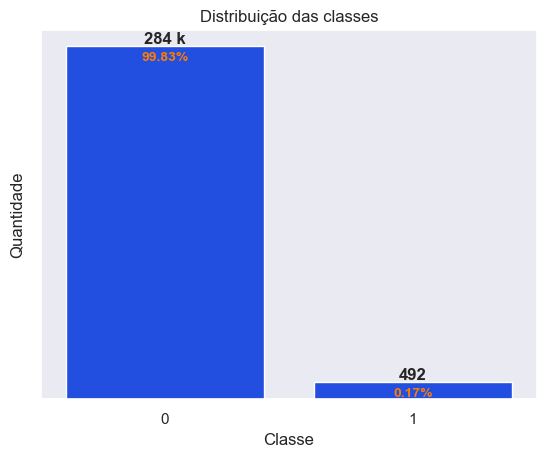

In [9]:
fig, ax = plt.subplots()

sns.countplot(data=df, x="Class", ax=ax)

eng_fmt = EngFormatter(places=0)
ax.yaxis.set_major_formatter(eng_fmt)

ax.set_yscale("log")

ax.bar_label(
    ax.containers[0],
    label_type="edge",
    weight="bold",
    labels=map(eng_fmt.format_eng, df["Class"].value_counts())
)

ax.bar_label(
    ax.containers[0],
    label_type="edge",
    weight="bold",
    labels=map(lambda num: f"{num:.2%}", df["Class"].value_counts(normalize=True)),
    padding=-12,
    fontsize=10,
    color="C1"
)

ax.set_title("Distribuição das classes")
ax.set_xlabel("Classe")
ax.set_ylabel("Quantidade")
ax.set_yticks([])

plt.show()

**Our initial detailed analysis of the dataset has already brought important revelations:**

**Data Structure (.info()):**
- **We confirmed that most of our "secret" columns (V1 to V28, originating from PCA) are of type float. The Time and Amount columns, our only non-anonymized clues, are also in suitable numerical formats.**

**Statistical Profile (.describe()):**
- **The "V" variables (PCA components) appear to be standardized, with means close to zero, as expected.**
- **The Amount variable (transaction value), on the other hand, exhibits significant variation in its values, indicating transactions of very diverse amounts, from very small to considerably large. This might require special attention during preprocessing.**

**The Fraud Target (Class):**
- **The distribution analysis of our target variable Class raised a major flag: we found an extreme imbalance. The ratio is approximately 1 fraudulent (positive) transaction for every 578 genuine (negative) transactions.**

**These findings are crucial. The large variation in Amount and, especially, the severe imbalance in the Class variable are challenges that will need to be carefully considered and addressed for us to build an effective fraud detection model.**

## Analyzing Differences Between Classes
**With the initial findings in mind, our investigation now delves deeper to understand how transaction characteristics differ between genuine and fraudulent ones. Our goal is to find the "signals" that might give away a fraud:**

- **Detailed Temporal Analysis: We will convert the Time column (currently in seconds) to hours. This will allow us to investigate if there's any hourly pattern or time of day when frauds are more common.**

- **Visualizing Disparities (Histograms and Boxplots): For each numerical variable (including the PCA components 'V1-V28', Time in hours, and Amount), we will create histograms and boxplots. These plots will be segmented by our target variable Class. We want to see if the "shape" of the distribution and the presence of outliers are visibly different between fraudulent (Class == 1) and genuine (Class == 0) transactions.**

- **Relationship Map (Correlation Heatmap): We will generate a correlation heatmap to visualize the relationships between numerical variables. Our expectation, given that V1-V28 are PCA results, is that there will be little to no correlation among them. However, we will be alert to possible correlations of Time and Amount with the Class variable or with each other.**

- **Statistical Significance Test (Mann-Whitney U): To go beyond visual analysis, we will apply the Mann-Whitney U test. This non-parametric test will help us identify, with statistical rigor, which variables have significantly different distributions between fraudulent and genuine transactions. It's ideal for comparing two independent samples, especially when we cannot assume a normal data distribution.**

**This battery of analyses will provide us with more robust evidence on which features are the most promising for distinguishing and, in the future, predicting fraud.**

In [10]:
# Calculate the maximum value in the "Time" column and convert it to hours
df["Time"].max() / 60 / 60

47.99777777777778

In [11]:
# Create a balanced sample DataFrame 'df_sample' by taking 492 random samples from each group in the "Class" column
df_sample = df.groupby("Class").sample(n=492, random_state=RANDOM_STATE)
df_sample.head()      # Display the first few rows of the newly created balanced sample DataFrame

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
138028,82450.0,1.314539,0.590643,-0.666593,0.716564,0.301978,-1.125467,0.388881,-0.288390,-0.132137,...,-0.170307,-0.429655,-0.141341,-0.200195,0.639491,0.399476,-0.034321,0.031692,0.76,0
63099,50554.0,-0.798672,1.185093,0.904547,0.694584,0.219041,-0.319295,0.495236,0.139269,-0.760214,...,0.202287,0.578699,-0.092245,0.013723,-0.246466,-0.380057,-0.396030,-0.112901,4.18,0
73411,55125.0,-0.391128,-0.245540,1.122074,-1.308725,-0.639891,0.008678,-0.701304,-0.027315,-2.628854,...,-0.133485,0.117403,-0.191748,-0.488642,-0.309774,0.008100,0.163716,0.239582,15.00,0
164247,116572.0,-0.060302,1.065093,-0.987421,-0.029567,0.176376,-1.348539,0.775644,0.134843,-0.149734,...,0.355576,0.907570,-0.018454,-0.126269,-0.339923,-0.150285,-0.023634,0.042330,57.00,0
148999,90434.0,1.848433,0.373364,0.269272,3.866438,0.088062,0.970447,-0.721945,0.235983,0.683491,...,0.103563,0.620954,0.197077,0.692392,-0.206530,-0.021328,-0.019823,-0.042682,0.00,0


In [12]:
# Count the occurrences of each unique value in the "Class" column of the 'df_sample'
df_sample["Class"].value_counts()

Class
0    492
1    492
Name: count, dtype: int64

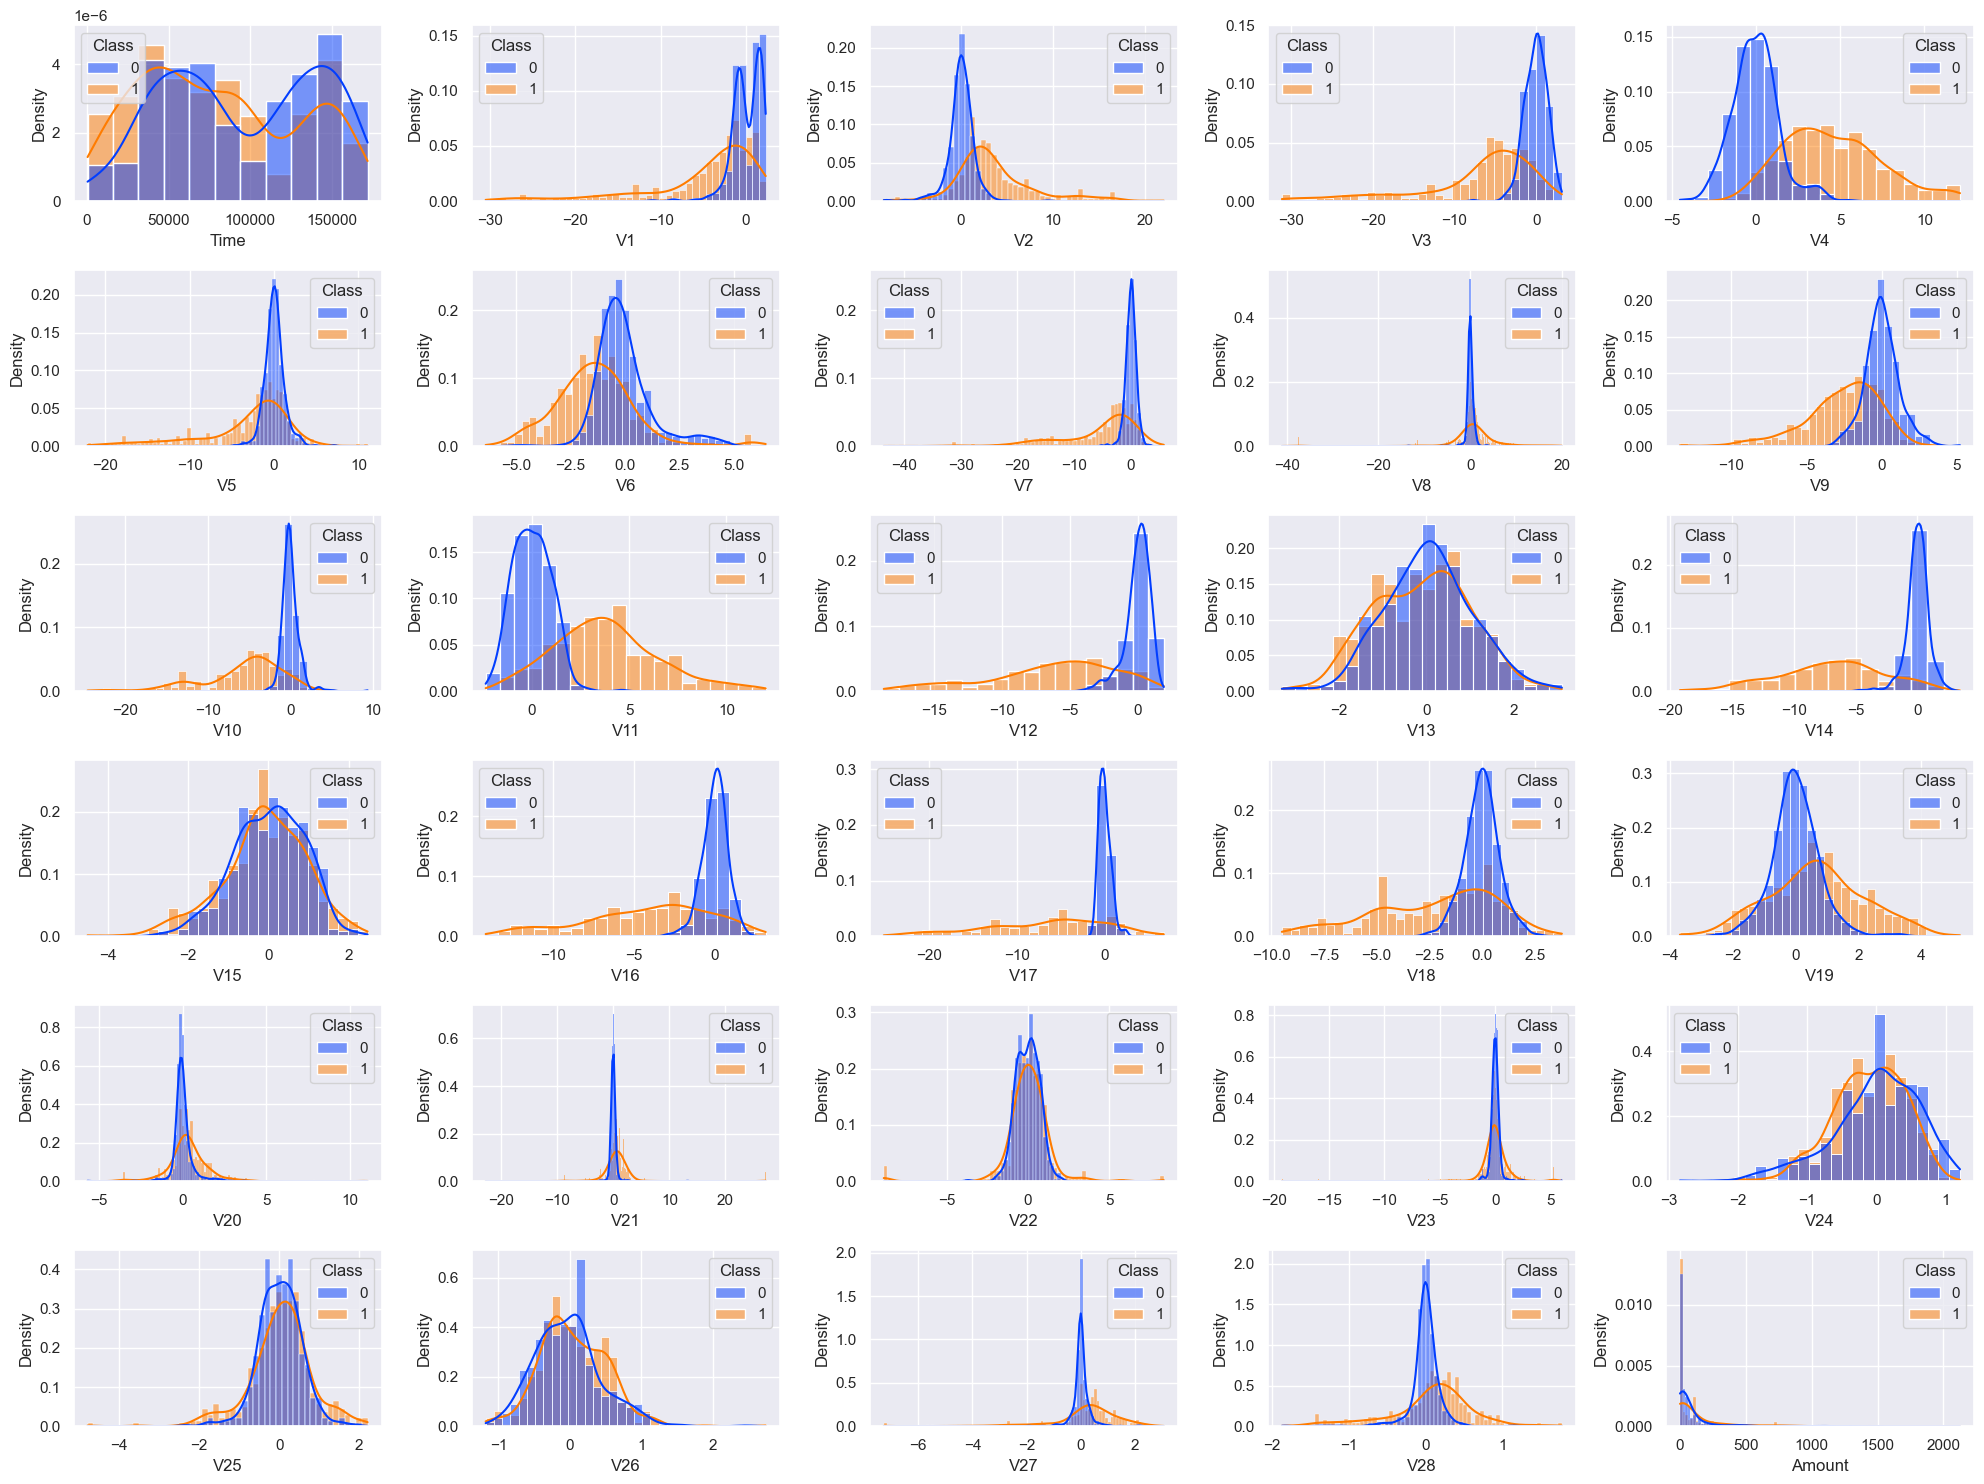

In [13]:
# Create a figure and a 6x5 grid of subplots, with a specified overall figure size.
fig, axs = plt.subplots(6, 5, figsize=(20, 15))

# Iterate through each subplot axis (ax) and each column name (coluna) in the 'df_sample'
# 'axs.flatten()' converts the 2D array of axes into a 1D array for easy iteration
for ax, coluna in zip(axs.flatten(), df_sample.columns):
    sns.histplot(data=df_sample, x=coluna, ax=ax, kde=True, hue="Class", stat="density")       # Create a histogram for the current column ('coluna') on the current subplot axis ('ax')

plt.tight_layout()   # Adjust subplot parameters to provide a tight layout, preventing titles and labels from overlapping.
plt.show()           # Display the generated figure with all the histograms

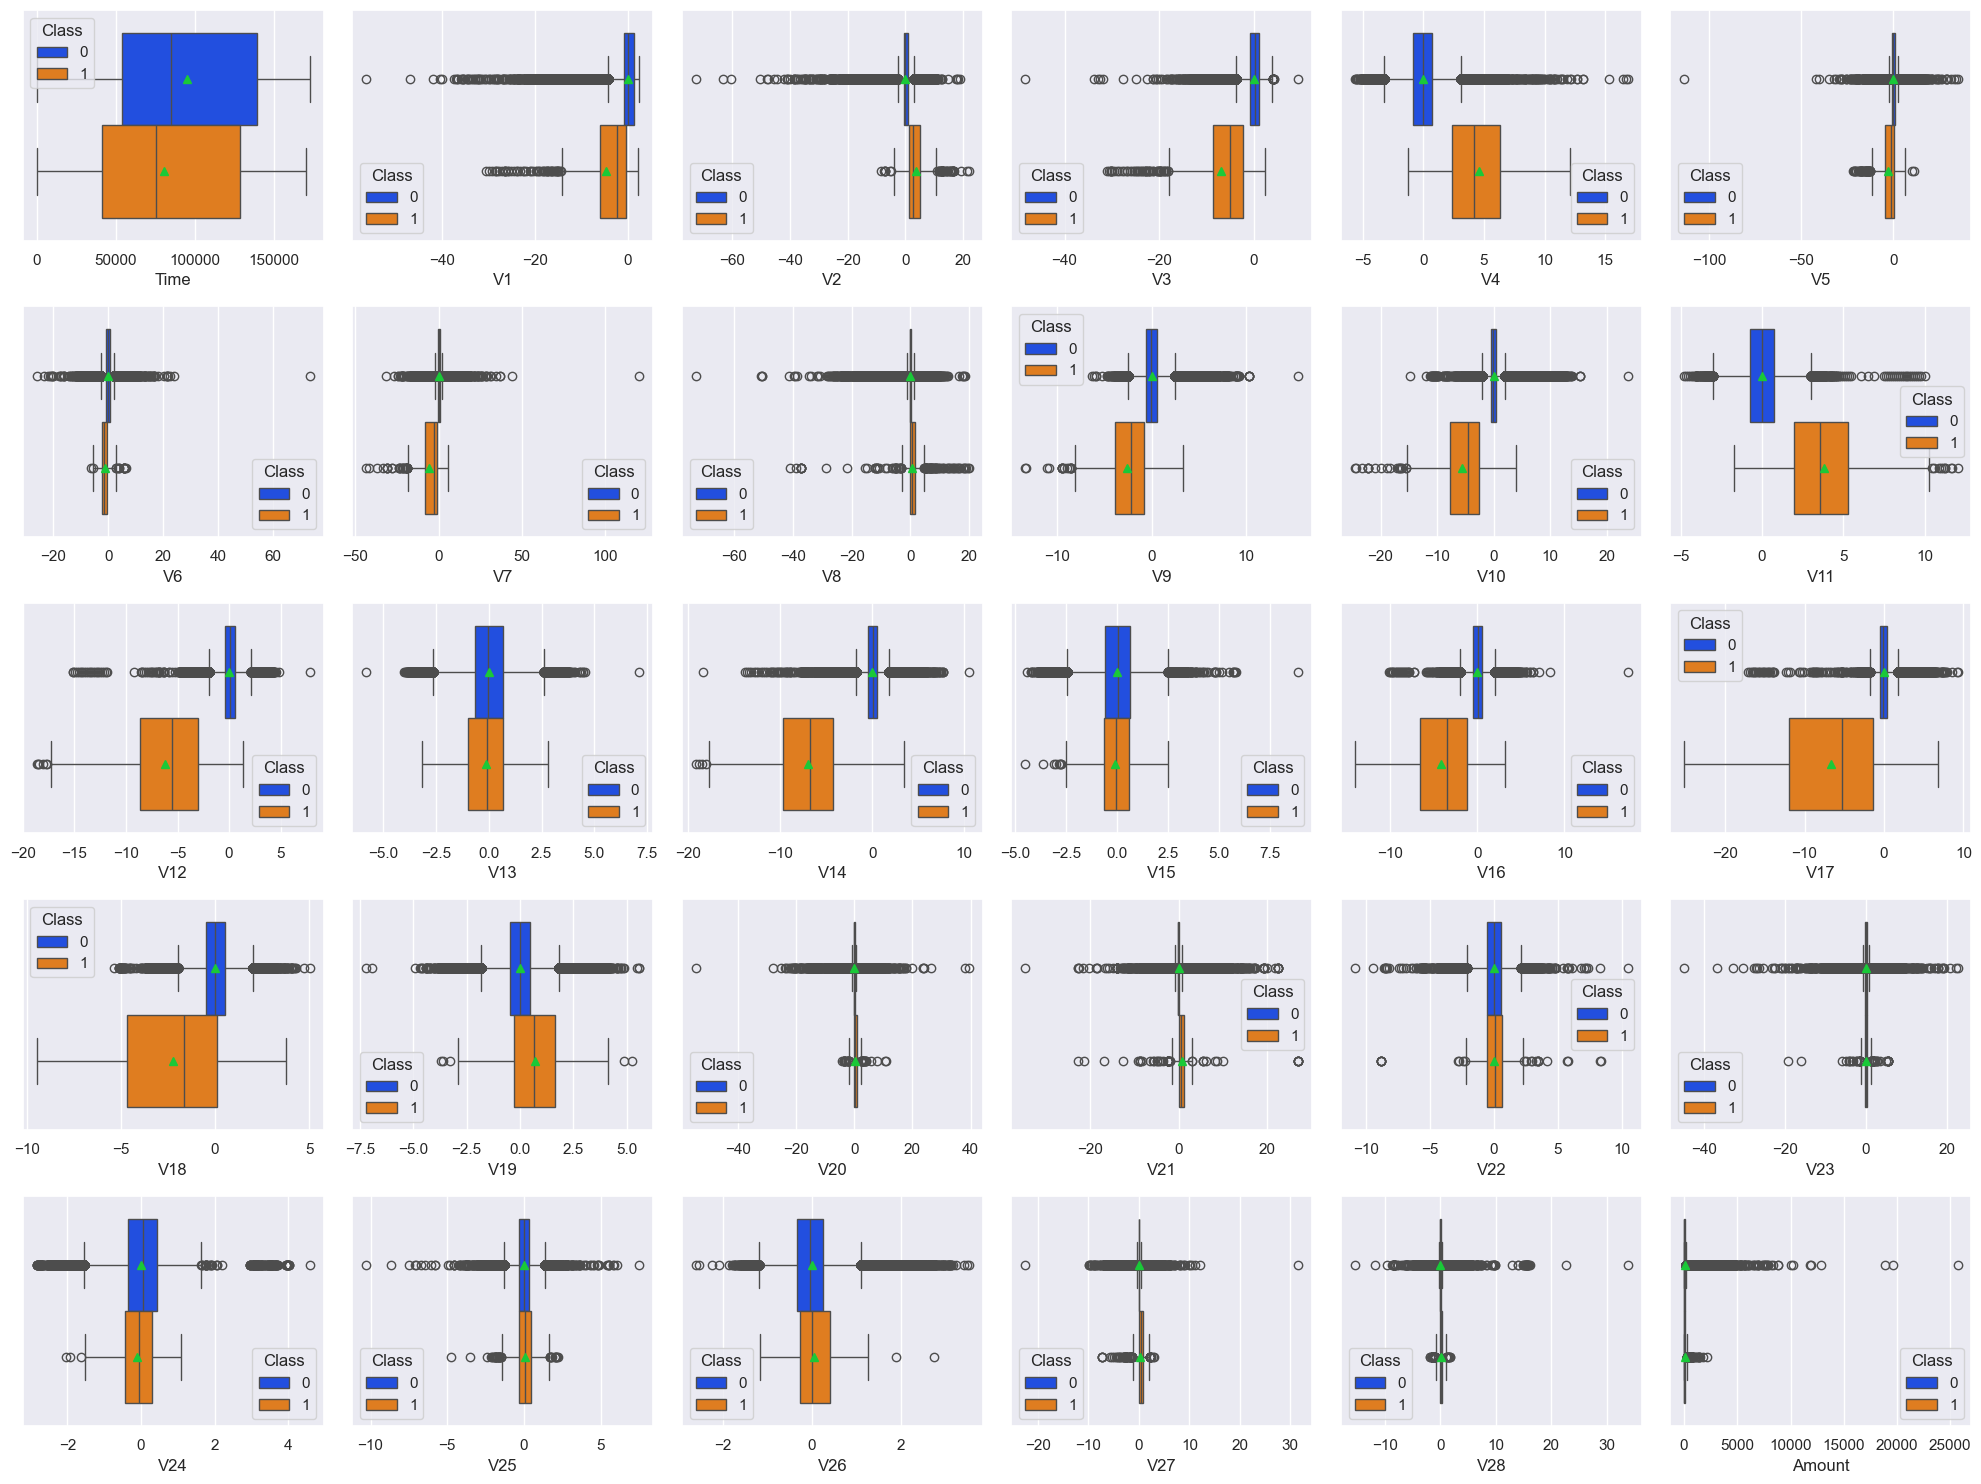

In [14]:
# Create a figure and a 5x6 grid of subplots, with a specified overall figure size.
fig, axs = plt.subplots(5, 6, figsize=(20, 15))

# Iterate through each subplot axis (ax) and each column name (coluna) in the DataFrame 'df'.
# 'axs.flatten()' converts the 2D array of axes into a 1D array for easy iteration.
for ax, coluna in zip(axs.flatten(), df.columns):
    sns.boxplot(data=df, x=coluna, ax=ax, showmeans=True, hue="Class")         # Create a boxplot for the current column ('coluna') on the current subplot axis ('ax').

plt.tight_layout()      # Adjust subplot parameters to provide a tight layout, preventing titles and labels from overlapping.
plt.show()              # Display the generated figure with all the boxplots.

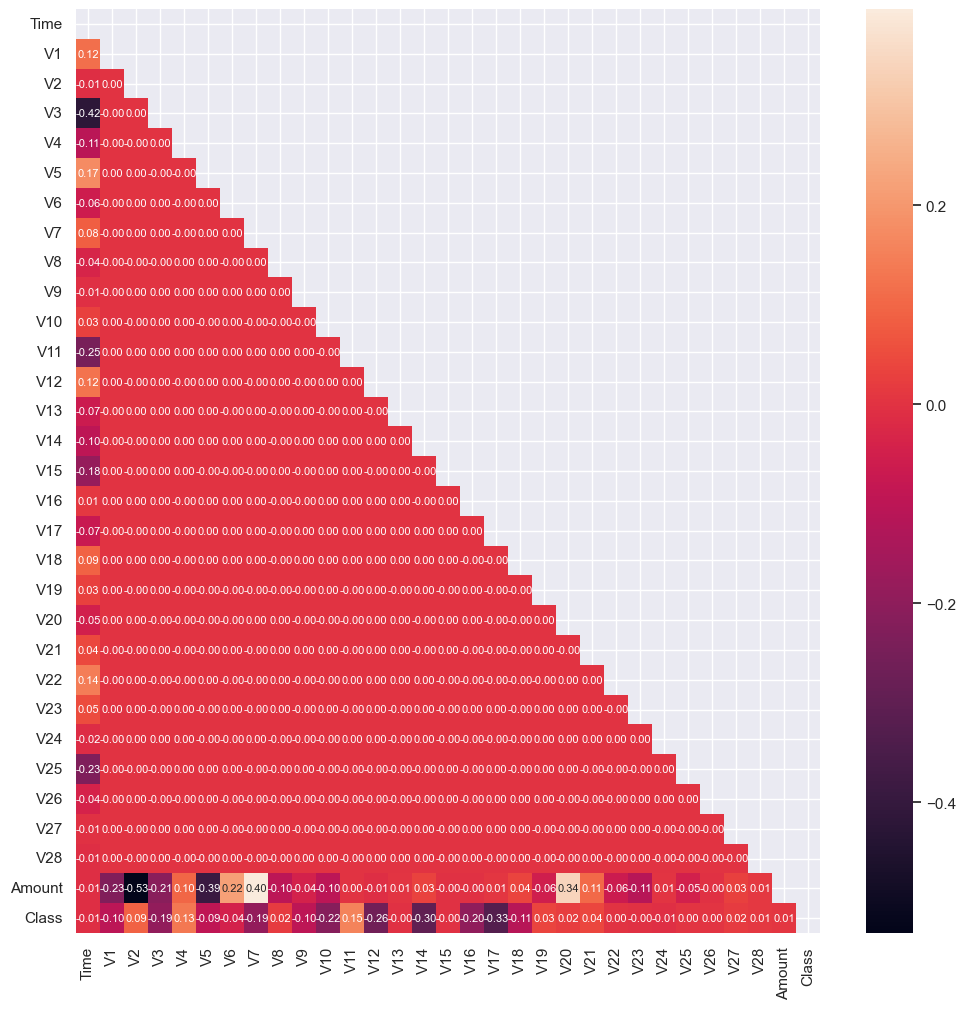

In [15]:
# Calculate the correlation matrix for all numerical columns in the DataFrame
corr = df.select_dtypes("number").corr()     

matriz = np.triu(corr)      # Create an upper triangle mask from the correlation matrix

fig, ax = plt.subplots(figsize=(12,12))      # Create a new figure and a single subplot (axes) with a specified size

# Generate and display a heatmap of the correlation matrix
sns.heatmap(
    corr,              # The correlation data to plot
    mask=matriz,       # Apply the mask to show only the lower triangle
    annot=True,        # Display the correlation values on the heatmap cells
    fmt=".2f",         # Format annotation values to two decimal places
    ax=ax,             # Draw the heatmap on the specified axes
    annot_kws={"fontsize": 8}     # Set the font size for annotations
)

# Show the generated heatmap plot
plt.show()

In [16]:
# Create a list of feature names by excluding the 'Class' (target) column
features = df.columns.drop("Class").to_list()

# Define the target column name
coluna_target = "Class"

# Initialize an empty dictionary to store Mann-Whitney U test results
analise_mw = {}

# Get the unique classes from the target column
classes = df[coluna_target].unique()

# Set the significance level (alpha) for statistical tests
alfa = 0.01

# Group the DataFrame by the target column for comparative analysis
agrupamento = df.groupby(coluna_target)

In [17]:
# Iterate through each feature name in the 'features' list
for coluna in features:
    # Get the data for the current feature ('coluna') for the first class
    grupo1 = agrupamento.get_group(classes[0])[coluna]     
    grupo2 = agrupamento.get_group(classes[1])[coluna]
    
    # Perform the Mann-Whitney U test to compare the distributions of 'grupo1' and 'grupo2'.
    estatistica_mw, pvalue_mw = mannwhitneyu(grupo1, grupo2)

    # Store the results of the Mann-Whitney U test for the current feature.
    # This includes the p-value, the test statistic, and a boolean indicating
    # if the p-value is less than the predefined significance level 'alfa'.
    analise_mw[coluna] = {
        "pvalue": pvalue_mw, 
        "estatistica": estatistica_mw,
        "relacao_significativa": pvalue_mw < alfa, # True if statistically significant
    }

# Convert the dictionary of Mann-Whitney U test results into a pandas DataFrame.
df_mw = pd.DataFrame(analise_mw).T
df_mw      # Display the DataFrame containing the Mann-Whitney U test results for each feature.

,pvalue,estatistica,relacao_significativa
Time,0.0,81310602.0,True
V1,0.0,111193870.0,True
V2,0.0,20289296.0,True
V3,0.0,127583455.0,True
V4,0.0,8636598.0,True
V5,0.0,99256726.0,True
V6,0.0,107291012.0,True
V7,0.0,116915822.0,True
V8,0.0,47862020.0,True
V9,0.0,118073844.0,True


In [18]:
# Filter the 'df_mw' DataFrame to show features where the Mann-Whitney U test
df_mw.query("relacao_significativa == False")

,pvalue,estatistica,relacao_significativa
V13,0.051215,73493959.0,False
V15,0.129508,72703847.0,False
V22,0.266395,67916421.0,False
V25,0.012463,65388547.0,False


**Our detailed investigation of the variables, comparing classes and their relationships, has brought crucial revelations:**

- **Temporal Pattern of Transactions: We observed that the transactions in the dataset occur over a two-day period. The analysis of Time (converted to hours) showed well-defined peaks and troughs, which might indicate peak business hours during the day and a natural reduction at night. This cyclicality could be a clue.**

- **Differentiating Variables: The comparative analysis (using histograms, boxplots, and the Mann-Whitney U test) was fundamental! We successfully identified variables that show significantly different distributions between fraudulent and genuine transactions. These are our "hot leads" – features that will likely be very important for our detection model.**

- **Independence of PCA Components: As expected, the correlation heatmap confirmed that the V variables (V1-V28), being the result of Principal Component Analysis (PCA), do not have significant correlation among themselves. This is good, as it indicates they carry distinct and non-redundant information for the model.**

**These discoveries are like pieces of a puzzle fitting together. They give us a better understanding of transaction dynamics and, more importantly, point towards the characteristics our model can use to "sniff out" the traces of fraud.**

## Refining the Clues: Outlier Treatment and Feature Selection:

**Our investigation moves forward, and now it's time to "clean up the crime scene," focusing on the most promising evidence:**

- **Strategic Outlier Treatment: We've identified outliers, but to avoid losing valuable information from the already small sample of fraudulent transactions (Class == 1), we will perform outlier treatment only on the majority class (genuine transactions, Class == 0). This surgical approach aims to reduce noise without compromising the rare examples of fraud.**

- **Removal of Non-Relevant Features: The Mann-Whitney U test helped us identify which variables do not show a statistically significant difference between fraudulent and genuine transactions (i.e., those where the hypothesis that the distributions are different was considered "False" or not proven by the test, with a high p-value). These columns, which don't help us distinguish between the two groups, will be removed. We want our model to focus only on the clues that truly indicate potential fraud.**

**With these actions, our dataset will become cleaner, more focused, and optimized, preparing the ground for our model to learn from the strongest and clearest signals.**

In [19]:
df_majoritaria = df[df["Class"] == 0]     # Create a DataFrame 'df_majoritaria' containing only instances of the majority class (Class == 0)
df_minoritaria = df[df["Class"] == 1]     # Create a DataFrame 'df_minoritaria' containing only instances of the minority class (Class == 1)

# Display the shapes (number of rows and columns) of the majority and minority class DataFrames
df_majoritaria.shape, df_minoritaria.shape

((284315, 31), (492, 31))

In [20]:
# Define a function to filter a DataFrame based on quantile ranges for specified variables
def remover_outliers_quantil(df, variaveis, quantil_inferior=0.05, quantil_superior=0.95):
    # Create a copy of the DataFrame (though its iterative filtering utility is bypassed later)
    df_filtrado = df.copy()
    # Iterate through each variable specified in the 'variaveis' list
    for variavel in variaveis:
        # Calculate the lower quantile limit for the current 'variavel' from the original DataFrame
        limite_inferior = df[variavel].quantile(quantil_inferior)
        # Calculate the upper quantile limit for the current 'variavel' from the original DataFrame
        limite_superior = df[variavel].quantile(quantil_superior)
        # Filter the original DataFrame to include only rows where the current 'variavel'
        df_filtrado = df[(df[variavel] >= limite_inferior) & (df[variavel] <= limite_superior)]
    # Return the 'df_filtrado', which will reflect the filtering based on the last 'variavel' processed
    return df_filtrado

In [21]:
# Define the list of variables (features) to consider for outlier removal
variaveis = df.columns.drop("Class")

# Apply the 'remover_outliers_quantil' function to the majority class DataFrame ('df_majoritaria')
df_majoritaria_filtrado = remover_outliers_quantil(df_majoritaria, variaveis)

# Display the shape (number of rows and columns) of the filtered majority class DataFrame
df_majoritaria_filtrado.shape

(256088, 31)

In [22]:
# Concatenate (combine) the filtered majority class DataFrame ('df_majoritaria_filtrado') with the original minority class DataFrame ('df_minoritaria')
df_sem_outliers = pd.concat([df_majoritaria_filtrado, df_minoritaria])

# Display the shape (number of rows and columns) of the combined DataFrame 'df_sem_outliers'
df_sem_outliers.shape

(256580, 31)

In [23]:
# Reset the index of the 'df_sem_outliers' DataFrame
df_sem_outliers = df_sem_outliers.reset_index(drop=True)

# Display the first few rows of the DataFrame 'df_sem_outliers' with the reset index
df_sem_outliers.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
3,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
4,2.0,-0.425966,0.960523,1.141109,-0.168252,0.420987,-0.029728,0.476201,0.260314,-0.568671,...,-0.208254,-0.559825,-0.026398,-0.371427,-0.232794,0.105915,0.253844,0.081080,3.67,0


In [24]:
# Calculate and display the relative frequencies (proportions) of each unique value in the "Class" column
df_sem_outliers["Class"].value_counts(normalize=True)

Class
0    0.998082
1    0.001918
Name: proportion, dtype: float64

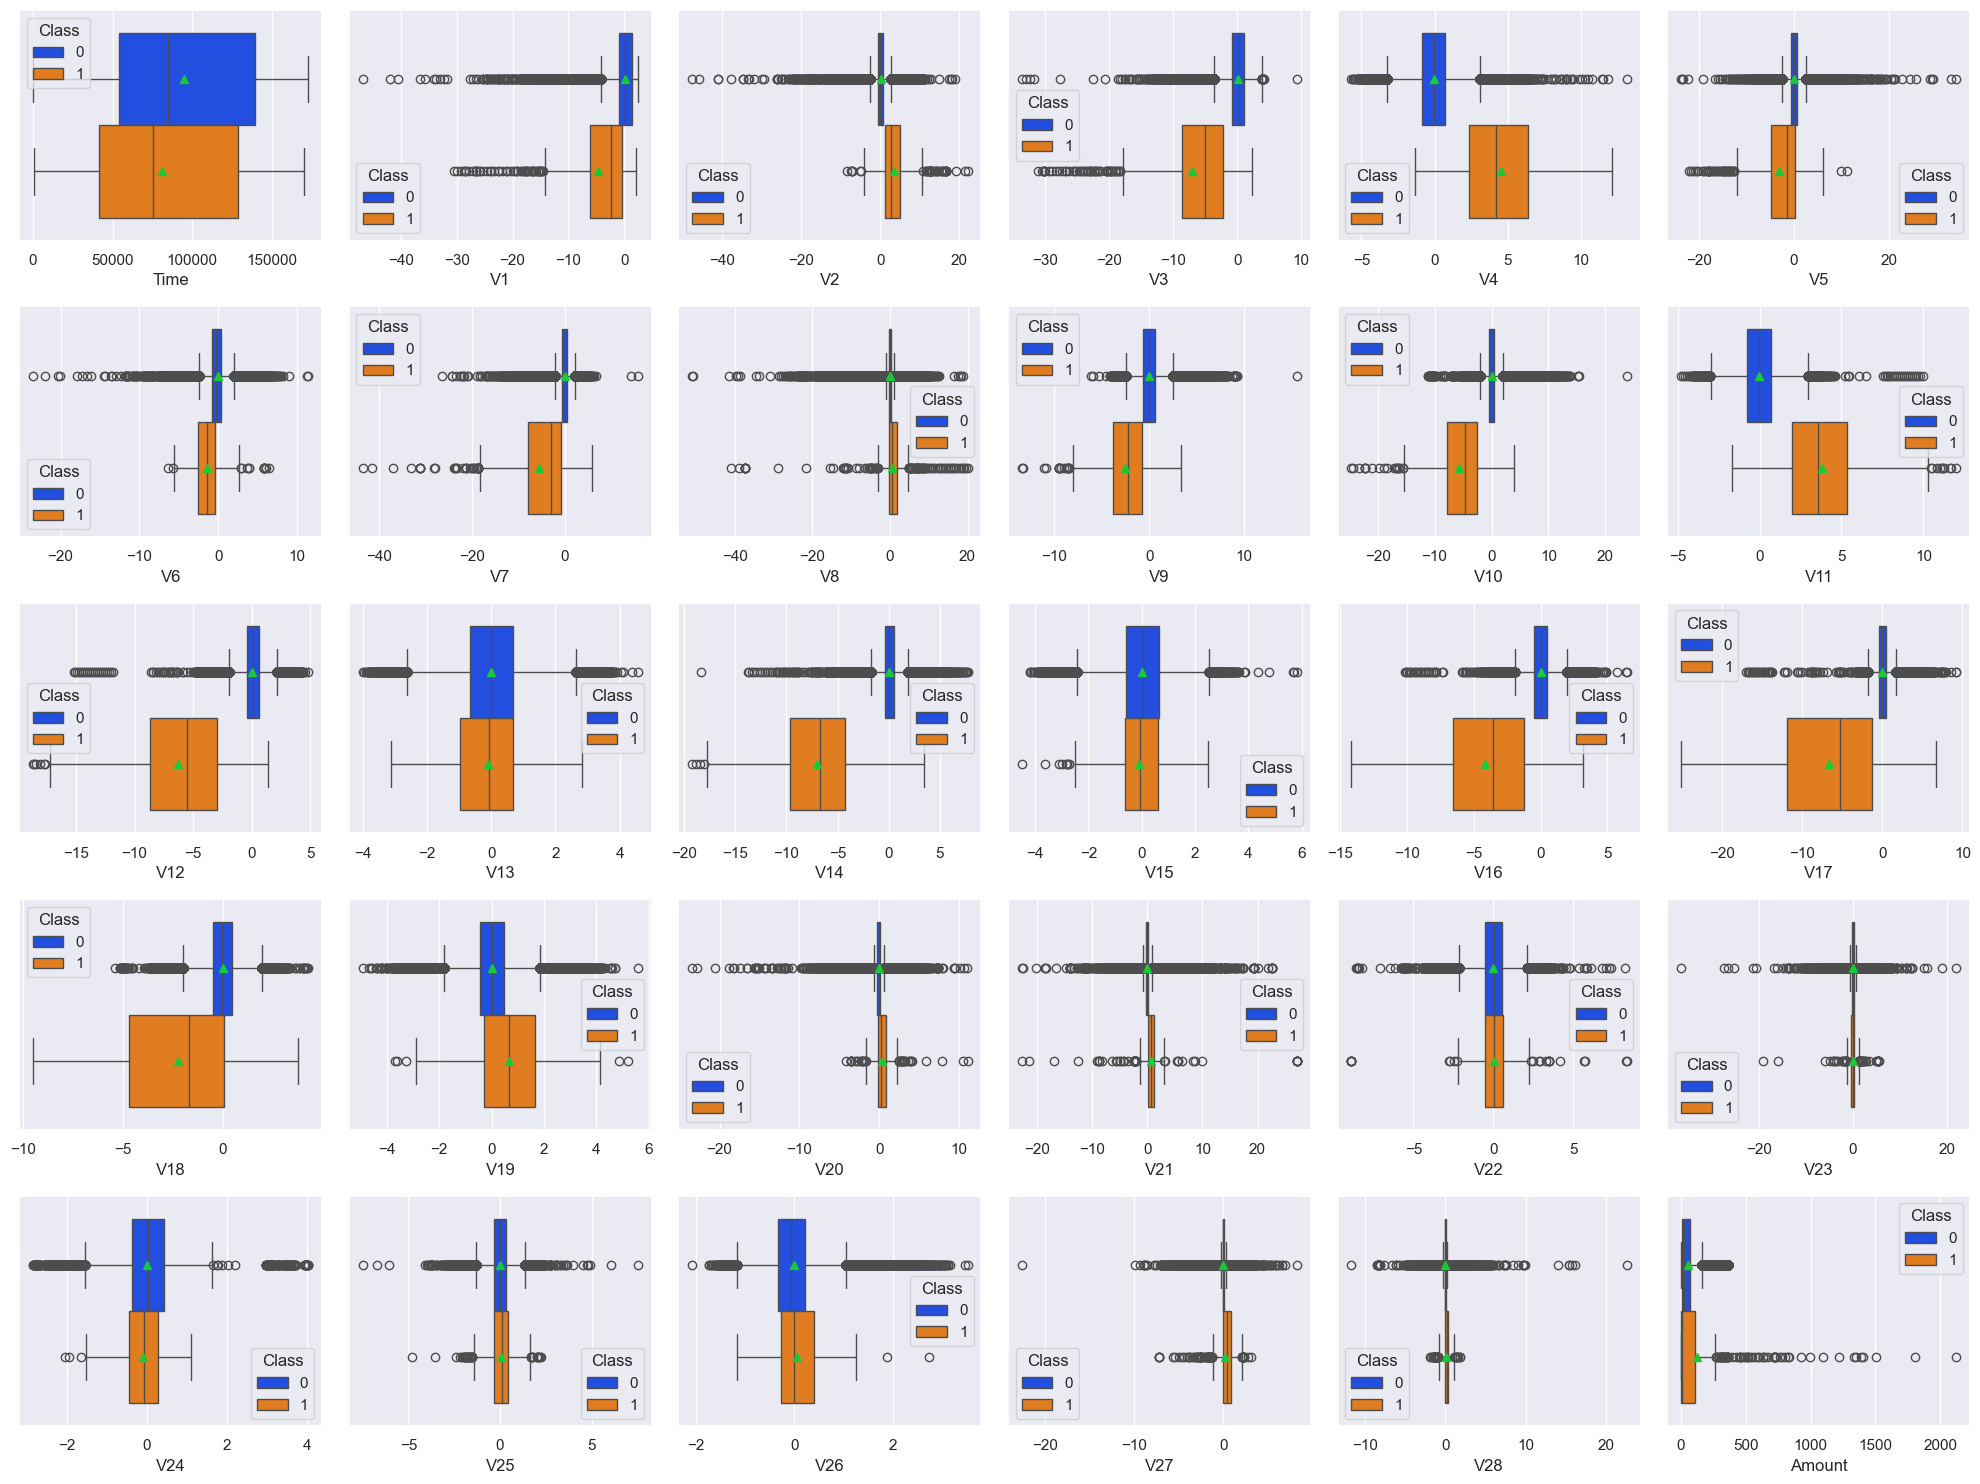

In [25]:
# Create a figure and a 5x6 grid of subplots, with a specified overall figure size
fig, axs = plt.subplots(5, 6, figsize=(20, 15))

# Iterate through each subplot axis (ax) and each column name (coluna) in the 'df_sem_outliers' DataFrame.
# 'axs.flatten()' converts the 2D array of axes into a 1D array for easy iteration.
for ax, coluna in zip(axs.flatten(), df_sem_outliers.columns):
    sns.boxplot(data=df_sem_outliers, x=coluna, ax=ax, showmeans=True, hue="Class")    # Create a boxplot for the current column ('coluna') on the current subplot axis ('ax').

# Adjust subplot parameters to provide a tight layout, preventing titles and labels from overlapping.
plt.tight_layout()

# Display the generated figure with all the boxplots.
plt.show()

In [26]:
# Print a concise summary of the 'df_sem_outliers' DataFrame
df_sem_outliers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 256580 entries, 0 to 256579
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    256580 non-null  float64
 1   V1      256580 non-null  float64
 2   V2      256580 non-null  float64
 3   V3      256580 non-null  float64
 4   V4      256580 non-null  float64
 5   V5      256580 non-null  float64
 6   V6      256580 non-null  float64
 7   V7      256580 non-null  float64
 8   V8      256580 non-null  float64
 9   V9      256580 non-null  float64
 10  V10     256580 non-null  float64
 11  V11     256580 non-null  float64
 12  V12     256580 non-null  float64
 13  V13     256580 non-null  float64
 14  V14     256580 non-null  float64
 15  V15     256580 non-null  float64
 16  V16     256580 non-null  float64
 17  V17     256580 non-null  float64
 18  V18     256580 non-null  float64
 19  V19     256580 non-null  float64
 20  V20     256580 non-null  float64
 21  V21     25

In [27]:
# Remove features from 'df_sem_outliers' that were found to have no statistically significant
df_sem_outliers = df_sem_outliers.drop(
    columns=df_mw.query("relacao_significativa == False").index
)

# Display the new shape (number of rows and columns) of 'df_sem_outliers'
df_sem_outliers.shape

(256580, 27)

**After our focused intervention on the outliers of the majority class, we observed a reduction in the volume of this data. However, since our approach was more about "trimming the edges" – removing only the most extreme values (the largest and smallest outliers) and not a drastic pruning, the loss was not excessive. The main goal was to refine the majority class, reducing the noise caused by these discrepant values, without discarding a very large portion of information that might still be relevant for understanding the standard behavior of genuine transactions. We maintained the balance!**

## Saving the Refined Dataset:
**With outlier treatment and feature selection completed, our dataset is cleaner and more focused on the most relevant clues for uncovering fraud. To consolidate all this work and ensure we have a solid starting point for modeling, we will now save this processed version of our dataset. This way, we preserve our carefully prepared "evidence"!**

In [28]:
# Save the processed DataFrame 'df_sem_outliers' to a Parquet file.
df_sem_outliers.to_parquet(PROCESSED_DATA, index=False)